## Reading member galaxies of SDSS Centrals

This notebook reads the member galaxies of SDSS defined BCGs. 

Algorithm:
1. Select SDSS Centrals.
2. Detect DESI member galaxies around the centrals.
3. Construct kernels around the central
4. Best fit parameters

Plots to show:
* Split by magnitude
* Split by richness bins
* Redshift slices. 

In [1]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/DESI')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
datadir = data_dir()
plotdir = plots_dir()
bpmapdir = bpmap_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [2]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Inputting the catalog

In [4]:
DESI_directory = '/pscratch/sd/z/zwshao/shared_zzhang13/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.3/'

In [5]:
for name in os.listdir(DESI_directory):
    print(name)

BGS_BRIGHT-21.5_full_HPmapcut.dat.fits
BGS_ANY_NGC_clustering.dat.fits
BGS_BRIGHT_full_HPmapcut.dat.fits
BGS_ANY_SGC_clustering.dat.fits
LRG_clustering.dat.fits
LRG_full_noveto.dat.fits
BGS_ANY_full.dat.fits
BGS_ANY_full_HPmapcut.dat.fits
BGS_BRIGHT_NGC_clustering.dat.fits
BGS_BRIGHT-21.5_SGC_clustering.dat.fits
LRG+ELG_LOPnotqso_NGC_clustering.dat.fits
BGS_BRIGHT-21.5_clustering.dat.fits
BGS_ANY_clustering.dat.fits
LRG+ELG_LOPnotqso_SGC_clustering.dat.fits
LRG_full.dat.fits
BGS_BRIGHT_clustering.dat.fits
BGS_BRIGHT_SGC_clustering.dat.fits
LRG_NGC_clustering.dat.fits
LRG_full_HPmapcut.dat.fits
BGS_BRIGHT_full_noveto.dat.fits
BGS_BRIGHT-21.5_NGC_clustering.dat.fits
BGS_ANY_full_noveto.dat.fits
BGS_BRIGHT_full.dat.fits
LRG_SGC_clustering.dat.fits


### Importing SDSS redMaPPer file

In [6]:
with open('RM_SDSS_df.pkl', 'rb') as handle:
    RM_df = pickle.load(handle)

In [7]:
rm_data = Table.from_pandas(RM_df)

In [8]:
rm_data.dtype

dtype([('ID', '<i4'), ('NAME', 'S20'), ('RA_x', '<f8'), ('DEC_x', '<f8'), ('Z_LAMBDA', '<f4'), ('Z_LAMBDA_ERR', '<f4'), ('LAMBDA', '<f4'), ('LAMBDA_ERR', '<f4'), ('S', '<f4'), ('Z_SPEC_x', '<f4'), ('OBJID_x', '<i8'), ('IMAG_x', '<f4'), ('IMAG_ERR_x', '<f4'), ('MODEL_MAG_U_x', '<f4'), ('MODEL_MAGERR_U_x', '<f4'), ('MODEL_MAG_G_x', '<f4'), ('MODEL_MAGERR_G_x', '<f4'), ('MODEL_MAG_R_x', '<f4'), ('MODEL_MAGERR_R_x', '<f4'), ('MODEL_MAG_I_x', '<f4'), ('MODEL_MAGERR_I_x', '<f4'), ('MODEL_MAG_Z_x', '<f4'), ('MODEL_MAGERR_Z_x', '<f4'), ('ILUM', '<f4'), ('RA_y', '<f8'), ('DEC_y', '<f8'), ('R', '<f4'), ('P', '<f4'), ('P_FREE', '<f4'), ('THETA_I', '<f4'), ('THETA_R', '<f4'), ('IMAG_y', '<f4'), ('IMAG_ERR_y', '<f4'), ('MODEL_MAG_U_y', '<f4'), ('MODEL_MAGERR_U_y', '<f4'), ('MODEL_MAG_G_y', '<f4'), ('MODEL_MAGERR_G_y', '<f4'), ('MODEL_MAG_R_y', '<f4'), ('MODEL_MAGERR_R_y', '<f4'), ('MODEL_MAG_I_y', '<f4'), ('MODEL_MAGERR_I_y', '<f4'), ('MODEL_MAG_Z_y', '<f4'), ('MODEL_MAGERR_Z_y', '<f4'), ('Z_SPEC_y

### Filter by cluster redshift

In [9]:
##Remove clusters with bad spectroscopic redshift. 
cut = np.where(rm_data['Z_SPEC_x'] > 0)
rm_data = rm_data[cut]

### Sparse sampling

In [10]:
sparse_sampling = 100
rm_data = rm_data[::sparse_sampling]

In [11]:
len(rm_data)

10402

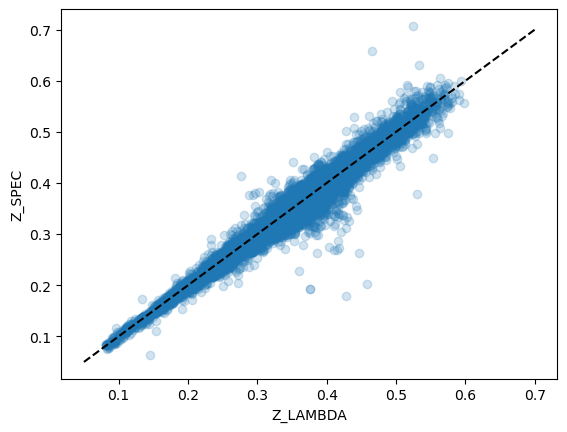

In [12]:
xline = np.linspace(0.05,0.7,100)
plt.scatter(rm_data['Z_LAMBDA'],rm_data['Z_SPEC_x'], alpha=0.2)
plt.plot(xline,xline, linestyle='--', color='black')
plt.xlabel('Z_LAMBDA'); plt.ylabel('Z_SPEC')
plt.show()

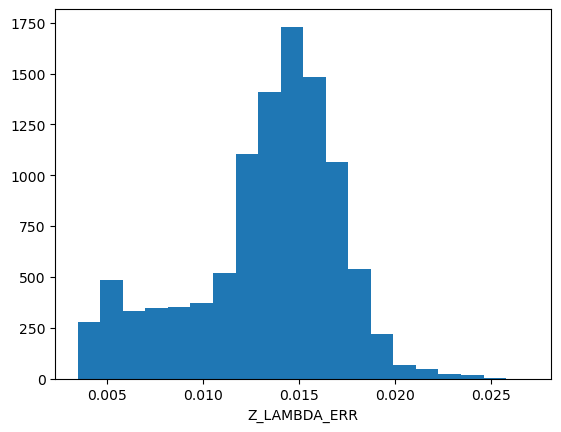

In [13]:
plt.hist(rm_data['Z_LAMBDA_ERR'], bins=20)
plt.xlabel('Z_LAMBDA_ERR')
plt.show()

### Filter RM by ID

In [14]:
from astropy import table
rm_data = table.unique(rm_data, keys='ID')

In [15]:
len(rm_data)

10070

## Reading BGS fits file

In [16]:
#Only record array pickle file
import pickle
from astropy.table import Table


bgs_file = DESI_directory + 'BGS_ANY_full.dat.fits'
bgs_data = Table.read(bgs_file)

In [17]:
bgs_data.dtype

dtype([('TARGETID', '>i8'), ('MWS_TARGET', '>i8'), ('SUBPRIORITY', '>f8'), ('PRIORITY_INIT', '>i8'), ('TARGET_STATE', 'S30'), ('TIMESTAMP', 'S25'), ('LOCATION', '>i8'), ('TILEID', '>i8'), ('TILELOCID', '>i8'), ('LASTNIGHT', '>i4'), ('Z_not4clus', '>f8'), ('ZERR', '>f8'), ('ZWARN', '>i8'), ('CHI2', '>f8'), ('COEFF', '>f8', (10,)), ('NPIXELS', '>i8'), ('SPECTYPE', 'S6'), ('SUBTYPE', 'S20'), ('NCOEFF', '>i8'), ('DELTACHI2', '>f8'), ('FIBER', '>i4'), ('COADD_FIBERSTATUS', '>i4'), ('FIBERASSIGN_X', '>f4'), ('FIBERASSIGN_Y', '>f4'), ('PRIORITY', '>i4'), ('COADD_NUMEXP', '>i2'), ('COADD_EXPTIME', '>f4'), ('COADD_NUMNIGHT', '>i2'), ('MEAN_DELTA_X', '>f4'), ('RMS_DELTA_X', '>f4'), ('MEAN_DELTA_Y', '>f4'), ('RMS_DELTA_Y', '>f4'), ('MEAN_PSF_TO_FIBER_SPECFLUX', '>f4'), ('TSNR2_ELG_B', '>f4'), ('TSNR2_LYA_B', '>f4'), ('TSNR2_BGS_B', '>f4'), ('TSNR2_QSO_B', '>f4'), ('TSNR2_LRG_B', '>f4'), ('TSNR2_ELG_R', '>f4'), ('TSNR2_LYA_R', '>f4'), ('TSNR2_BGS_R', '>f4'), ('TSNR2_QSO_R', '>f4'), ('TSNR2_LRG_R',

In [18]:
bgs_data.rename_column('Z_not4clus', 'Z')

In [19]:
len(bgs_data)

10805993

### Applying cuts

* ZWARN
* DELTACHI2 > 40
* SPECTYPE = 'galaxy'
* ZERR < (0.005)(1+z)

What about weights, redshift slices and color cuts?

In [20]:
len(np.where(bgs_data['ZWARN'] != 0)[0])/len(bgs_data)

0.4509058075458683

67604


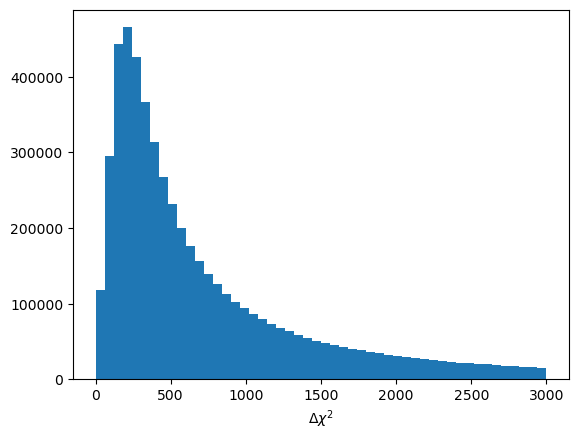

In [21]:
print(len(np.where(bgs_data['DELTACHI2'] < 40)[0]))
plt.hist(bgs_data['DELTACHI2'], bins=50, range=(0,3000))
plt.xlabel(r'$\Delta\chi^2$')
plt.show()

In [22]:
print(len(np.where(bgs_data['DELTACHI2'] < 40)[0])/len(bgs_data))

0.0062561580411906615


In [23]:
len(np.where(bgs_data['SPECTYPE'] != 'GALAXY')[0])

4973801

In [24]:
print(len(np.where(bgs_data['ZERR'] > 0.0005*(1+bgs_data['Z']))[0])/len(bgs_data))

2.0081449247653594e-05


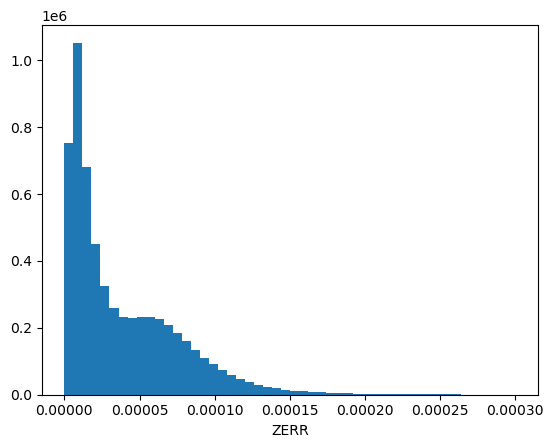

In [25]:

plt.hist(bgs_data['ZERR'], bins=50, range=(0,0.0003))
plt.xlabel('ZERR')
plt.show()

In [26]:
np.where(bgs_data['ZWARN'] != 0)

(array([       3,        4,        5, ..., 10805990, 10805991, 10805992]),)

In [27]:
cut = np.where((bgs_data['ZWARN'] == 0) & (bgs_data['ZERR'] <= 0.0005*(1+bgs_data['Z'])) & \
              (bgs_data['DELTACHI2'] >= 40) | (bgs_data['SPECTYPE'] == 'GALAXY'))  
print(len(cut[0]))

5951355


In [28]:
bgs_data_cut = bgs_data[cut]

### Plotting the n(z) distributions

In [29]:
z_arr = np.linspace(0,1,1000)
z_0 = 0.2; alpha = 2
n_z = 10*(z_arr/z_0)**2*np.exp(-(z_arr/z_0)**alpha)

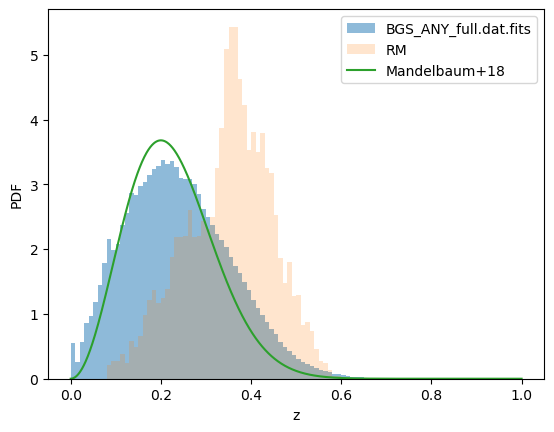

In [30]:
## How do you get the redshift information?
#names = [name for name in RM_data.dtype.names if len(RM_data[name].shape) <= 1]
plt.hist(bgs_data['Z'], range=(0,1), bins=100, alpha=0.5, density=True, label='BGS_ANY_full.dat.fits')
plt.hist(rm_data['Z_LAMBDA'], range=(0,1), bins=100, label='RM', alpha=0.2, density=True)
plt.plot(z_arr, n_z, label='Mandelbaum+18')
plt.xlabel('z')
plt.ylabel('PDF')
plt.legend()
plt.show()

## Match Catalogs by RA, DEC

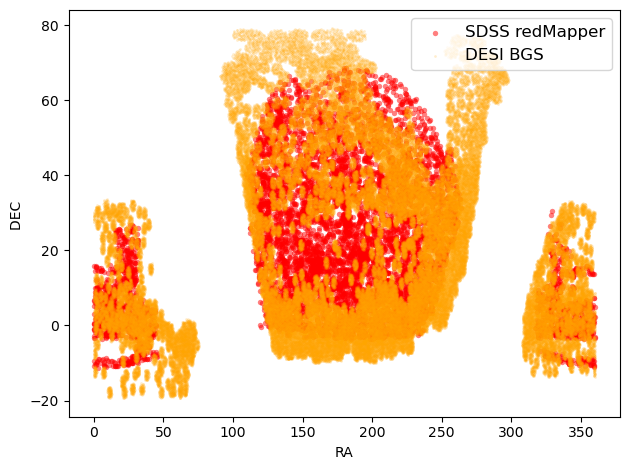

In [31]:
plt.scatter(rm_data['RA_x'], rm_data['DEC_x'], c='r', s=15, alpha=0.5, marker='o',linewidth=0.0, label='SDSS redMapper')
plt.scatter(bgs_data['RA'][::100], bgs_data['DEC'][::100], c='orange', marker='.', s=15, linewidth=0.0, alpha=0.2, label='DESI BGS')

plt.xlabel('RA'); plt.ylabel('DEC ')
plt.legend(fontsize=12, loc='upper right')
#plt.title('Position of halos and clusters')
plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

## Match galaxies with redMaPPer

Todo: Astropy has a built-in function to search around a 3D radius for a given cosmology. 

How to search around 2D radius in physical/comoving units?

In [32]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18

### Searching around angular distance
This is a first step as astropy does not permit searching around a 2D physical distance. 

In [33]:
rm_z = rm_data['Z_LAMBDA'] * cu.redshift
rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))

In [34]:
bgs_z = bgs_data['Z'] * cu.redshift
bgs_d = bgs_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))

In [35]:
## Masking the bad redshifts
bgs_d[np.where(bgs_d < 0)] = 0 

In [36]:
rm_c = SkyCoord(ra=rm_data['RA_x']*u.degree, dec=rm_data['DEC_x']*u.degree, distance = rm_d)

In [37]:
bgs_c = SkyCoord(ra=bgs_data['RA']*u.degree, dec=bgs_data['DEC']*u.degree, distance = bgs_d)

In [38]:
## Search around each RM
max_sep = 3.0 * u.arcmin
idxc, idxcatalog, d2d, d3d = bgs_c.search_around_sky(rm_c, max_sep)
np.all(d2d < max_sep)

True

In [39]:
rm_matched = rm_data[idxc]
bgs_matched = bgs_data[idxcatalog]

### Checking the matching algorithm

In [40]:
## Converting from spherical to cartesian

cos_theta_bgs = np.cos(np.deg2rad(bgs_matched['RA']))
cos_theta_rm = np.cos(np.deg2rad(rm_matched['RA_x']))
sin_theta_bgs = np.sin(np.deg2rad(bgs_matched['RA']))
sin_theta_rm = np.sin(np.deg2rad(rm_matched['RA_x']))
cos_phi_bgs = np.cos(np.deg2rad(bgs_matched['DEC']))
cos_phi_rm = np.cos(np.deg2rad(rm_matched['DEC_x']))
sin_phi_bgs = np.sin(np.deg2rad(bgs_matched['DEC']))
sin_phi_rm = np.sin(np.deg2rad(rm_matched['DEC_x']))

x_bgs = cos_theta_bgs*cos_phi_bgs
y_bgs = sin_theta_bgs*cos_phi_bgs
x_rm = cos_theta_rm*cos_phi_rm
y_rm = sin_theta_rm*cos_phi_rm
z_bgs = sin_phi_bgs
z_rm = sin_phi_rm

In [41]:
distance = np.rad2deg(np.sqrt((x_bgs-x_rm)**2 + (y_bgs-y_rm)**2 + (z_bgs-z_rm)**2))

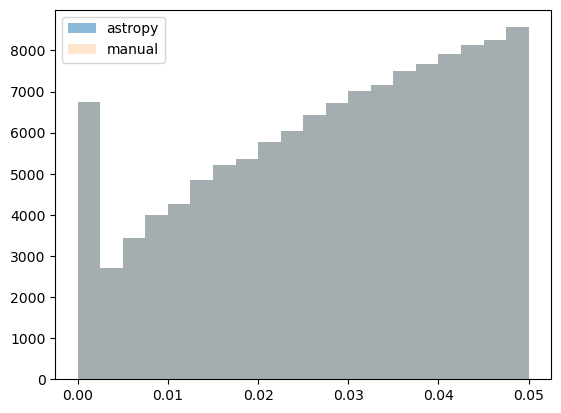

In [42]:
plt.hist(distance, bins=20, alpha=0.5, label = 'astropy')
plt.hist(d2d, bins=20, alpha=0.2, label = 'manual')
plt.legend()
plt.show()

### Search around physical 2D distance. 

Assuming galaxies and RM are same distance away from us. 

In [43]:
rm_z = rm_matched['Z_LAMBDA'] * cu.redshift
rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))

In [44]:
bgs_z = bgs_matched['Z'] * cu.redshift
bgs_d = bgs_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))

In [45]:
## Masking the bad redshifts
bgs_d[np.where(bgs_d < 0)] = 0 

In [46]:
#Match the galaxy distances on the sky to the matched RM distance

rm_c = SkyCoord(ra=rm_matched['RA_x']*u.degree, dec=rm_matched['DEC_x']*u.degree, distance = rm_d)
bgs_c = SkyCoord(ra=bgs_matched['RA']*u.degree, dec=bgs_matched['DEC']*u.degree, distance = rm_d)

In [47]:
## Search around each RM
max_sep = 1.0 * u.Mpc
idxc, idxcatalog, d2d, d3d = bgs_c.search_around_3d(rm_c, max_sep)
np.all(d3d < max_sep)

True

In [48]:
rm_matched = rm_matched[idxc]
bgs_matched = bgs_matched[idxcatalog]

In [49]:
print("Match rate: ", len(table.unique(rm_matched, keys='ID'))/len(rm_data)) ##There is a bug here. Why is match rate > 1??

Match rate:  0.626713008937438


## Plotting

* Split by magnitude
* Split by richness bins
* Redshift slices.

Make plots presentable.

In [50]:
#Bin by richness
lmda_bins = [[20,30],[30,50],[50,300]] #upper limit must match lower limit of next bin

## Bin by redshift
z_bins = [[0.15,0.2],[0.2,0.3],[0.3,0.4]]

In [1]:
small_bin = np.linspace(-0.01,0.01,1000)
wide_bin_1 = np.linspace(-0.1,-0.01,20)
wide_bin_2 = np.linspace(0.01,0.1,20)

binBoundaries = np.hstack((wide_bin_1, small_bin))
binBoundaries = np.hstack((binBoundaries, wide_bin_2))
binCent = np.asarray([(binBoundaries[i] + binBoundaries[i+1])/2 for i in range(len(binBoundaries)-1)])

NameError: name 'np' is not defined

In [52]:
len(binCent)

1039

In [381]:
z_diff = bgs_matched['Z'] - rm_matched['Z_SPEC_x']
val, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)
numCount, bin_edges = np.histogram(z_diff, bins=binBoundaries, density=False) 

##For Poissonian noise
#numCount[np.where(numCount<=0)] = 1 #Avoid dividing by 0 or NAN
#y_err = np.sqrt(numCount)
#y_err *= val/numCount
#y_err += 0.001 ## Add small number to avoid blowing up
y_err = np.sqrt(val)
y_err[np.where(y_err==0)] = 1




findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

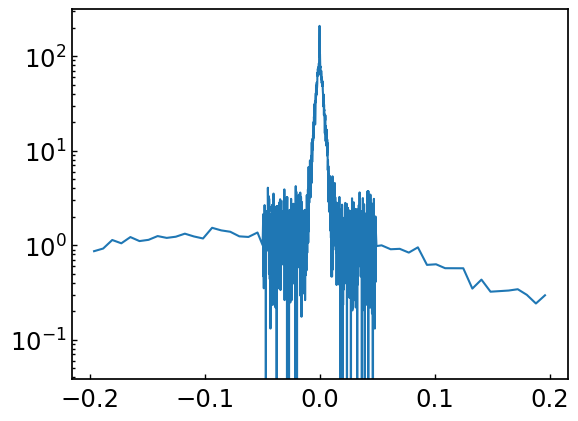

In [302]:
plt.plot(binCent, val)
plt.yscale('log')
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

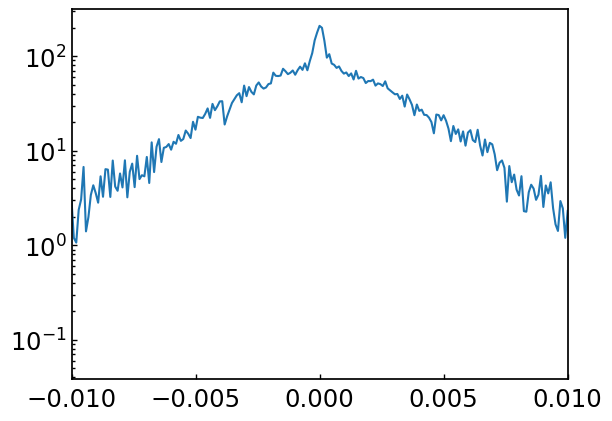

In [303]:
plt.plot(binCent, val)
plt.xlim([-0.01,0.01])
plt.yscale('log')
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

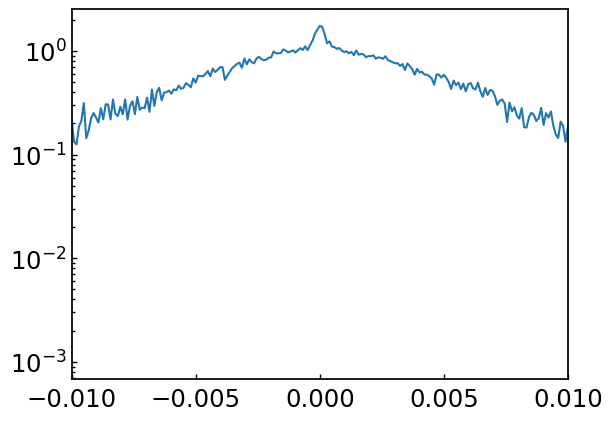

In [304]:
plt.plot(binCent, y_err)
plt.xlim([-0.01,0.01])
plt.yscale('log')
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

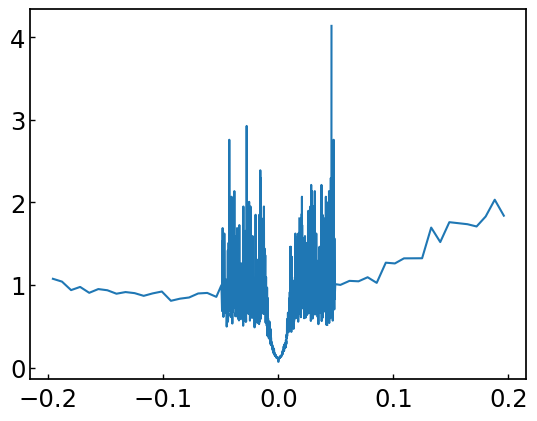

In [347]:
plt.plot(binCent, np.sqrt(val)/val)

## Fitting the continuum

In [96]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling.polynomial import Chebyshev1D, Polynomial1D
from astropy.modeling.functional_models import Linear1D
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
import linetools

In [97]:
spectrum = Spectrum1D(flux=val*u.Jy, spectral_axis=binCent*u.um)

In [98]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g1_fit = fit_generic_continuum(spectrum, model=Polynomial1D(3), median_window=3)

In [99]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g2_fit = fit_generic_continuum(spectrum, model=Chebyshev1D(3), median_window=3)

In [100]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g3_fit = fit_generic_continuum(spectrum, model=Linear1D(), median_window=3)

In [101]:
y_continuum_fitted_1 = g1_fit(binCent*u.um)
y_continuum_fitted_2 = g2_fit(binCent*u.um)
y_continuum_fitted_3 = g3_fit(binCent*u.um)

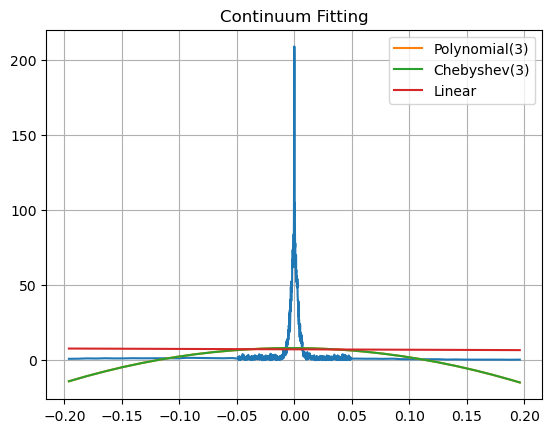

In [102]:
f, ax = plt.subplots()  
ax.plot(binCent, val)  
ax.plot(binCent, y_continuum_fitted_1, label='Polynomial(3)')  
ax.plot(binCent, y_continuum_fitted_2, label='Chebyshev(3)')  
ax.plot(binCent, y_continuum_fitted_3, label='Linear')  
ax.set_title("Continuum Fitting")  
ax.grid(True)  
plt.legend()
plt.show()

In [103]:
## Try excluding regions

from specutils import SpectralRegion
exclude_regions = [SpectralRegion(-0.05 * u.um, 0.05 * u.um)]

In [105]:
g1_fit = fit_generic_continuum(spectrum, model=Polynomial1D(3), median_window=3, exclude_regions=exclude_regions)
g2_fit = fit_generic_continuum(spectrum, model=Chebyshev1D(3), median_window=3, exclude_regions=exclude_regions)
g3_fit = fit_generic_continuum(spectrum, model=Linear1D(), median_window=3, exclude_regions=exclude_regions)

In [106]:
y_continuum_fitted_1 = g1_fit(binCent*u.um)
y_continuum_fitted_2 = g2_fit(binCent*u.um)
y_continuum_fitted_3 = g3_fit(binCent*u.um)

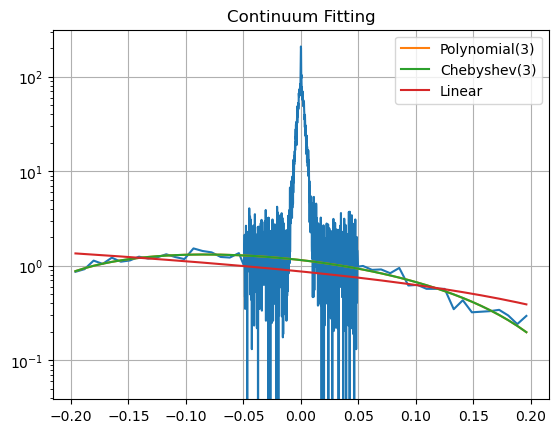

In [107]:
f, ax = plt.subplots()  
ax.plot(binCent, val)  
ax.plot(binCent, y_continuum_fitted_1, label='Polynomial(3)')  
ax.plot(binCent, y_continuum_fitted_2, label='Chebyshev(3)')  
ax.plot(binCent, y_continuum_fitted_3, label='Linear')  
ax.set_title("Continuum Fitting")  
ax.grid(True)  
plt.yscale('log')
plt.legend()
plt.show()

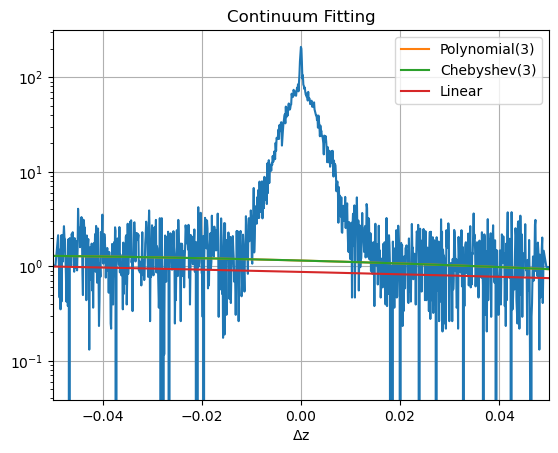

In [108]:
f, ax = plt.subplots()  
ax.plot(binCent, val)  
ax.plot(binCent, y_continuum_fitted_1, label='Polynomial(3)')  
ax.plot(binCent, y_continuum_fitted_2, label='Chebyshev(3)')  
ax.plot(binCent, y_continuum_fitted_3, label='Linear')  
ax.set_title("Continuum Fitting")  
ax.grid(True)  
plt.yscale('log')
plt.xlim([-0.05,0.05])
plt.xlabel(r'$\Delta$z')
plt.legend()
plt.show()

In [68]:
## To do. Test out different fitting models

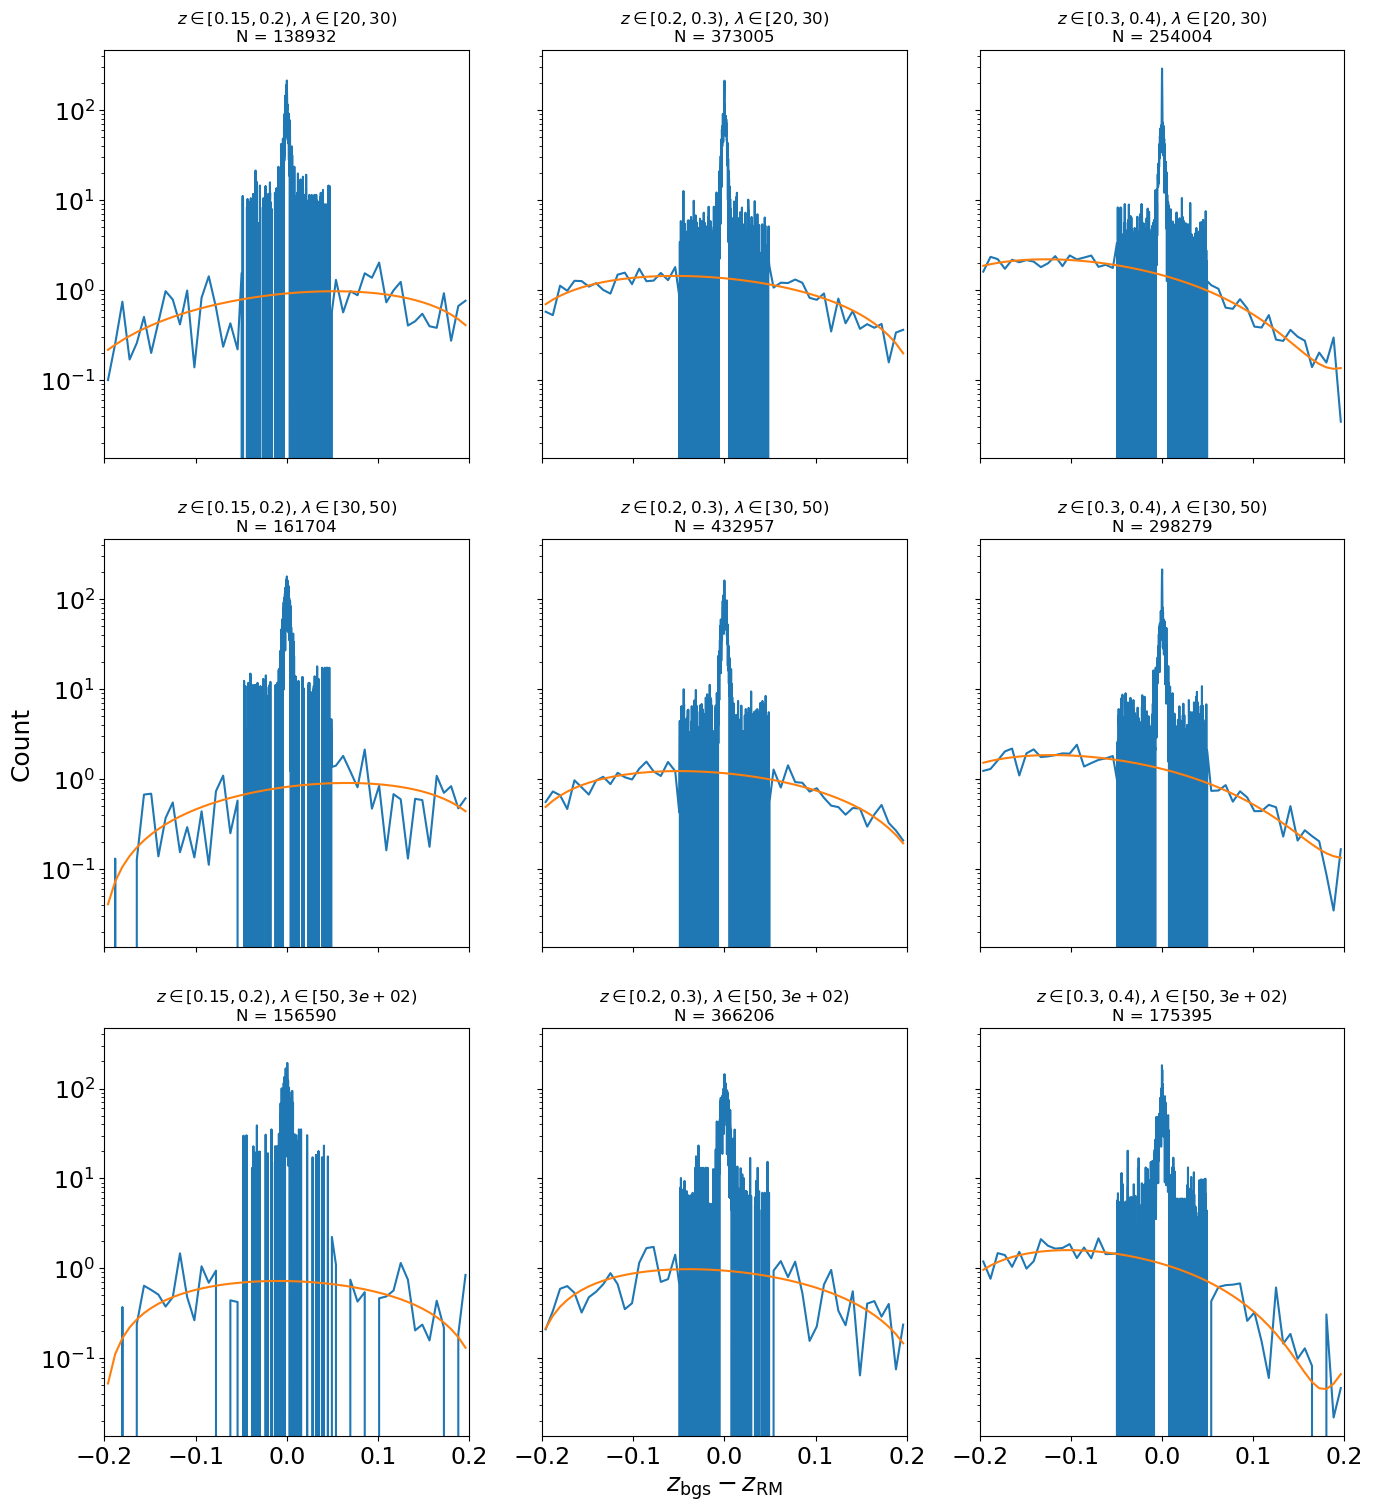

In [109]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,18), sharex='all', sharey='all')
#fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
for i, lmda_bin in enumerate(lmda_bins):
    #fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
    for j, z_bin in enumerate(z_bins):

            ##Apply cuts
            cut = (rm_matched['LAMBDA'] >= lmda_bin[0]) & (rm_matched['LAMBDA'] < lmda_bin[1])
            cut &=(rm_matched['Z_LAMBDA'] >= z_bin[0]) & (rm_matched['Z_LAMBDA'] < z_bin[1])
            rm_bin = rm_matched[cut]
            bgs_bin = bgs_matched[cut]


            z_diff = bgs_bin['Z'] - rm_bin['Z_SPEC_x']
            val, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)
            spectrum = Spectrum1D(flux=val*u.Jy, spectral_axis=binCent*u.um)
            g1_fit = fit_generic_continuum(spectrum, model=Chebyshev1D(3), median_window=3, exclude_regions=exclude_regions)
            y_continuum_fitted_1 = g1_fit(binCent*u.um)

            ax[i,j].plot(binCent, val)
            ax[i,j].plot(binCent, y_continuum_fitted_1)
            ax[i,j].set_yscale('log')
            ax[i,j].set_xlim([-0.2,0.2])
            #ax[i,j].hist(z_diff, bins=binBoundaries, density=True)
            ax[i,j].tick_params(axis='both', which='major', labelsize=17)
            ax[i,j].set_title(r'$z \in [{:.2g}, {:.2g})$, '.format(z_bin[0], z_bin[1],fontsize=12)+ \
                              r'$\lambda \in [{:.2g},{:.2g})$'.format(lmda_bin[0],lmda_bin[1],fontsize=12) + '\n' + \
                              'N = {:d}'.format(len(bgs_bin)))
            #ax[i,j].axhline(0.0, linestyle='--')
           
            ax[1,0].set_ylabel(r"Count", fontsize=18)
            ax[2,1].set_xlabel(r"$z_{\rm{bgs}} - z_{\rm{RM}}$"  , fontsize=18)
            
#plt.savefig('delta_z_bgs_rm_fullcut_zoomin.png')

plt.show()
#ax[0,0].legend(loc='upper left', fontsize=19)

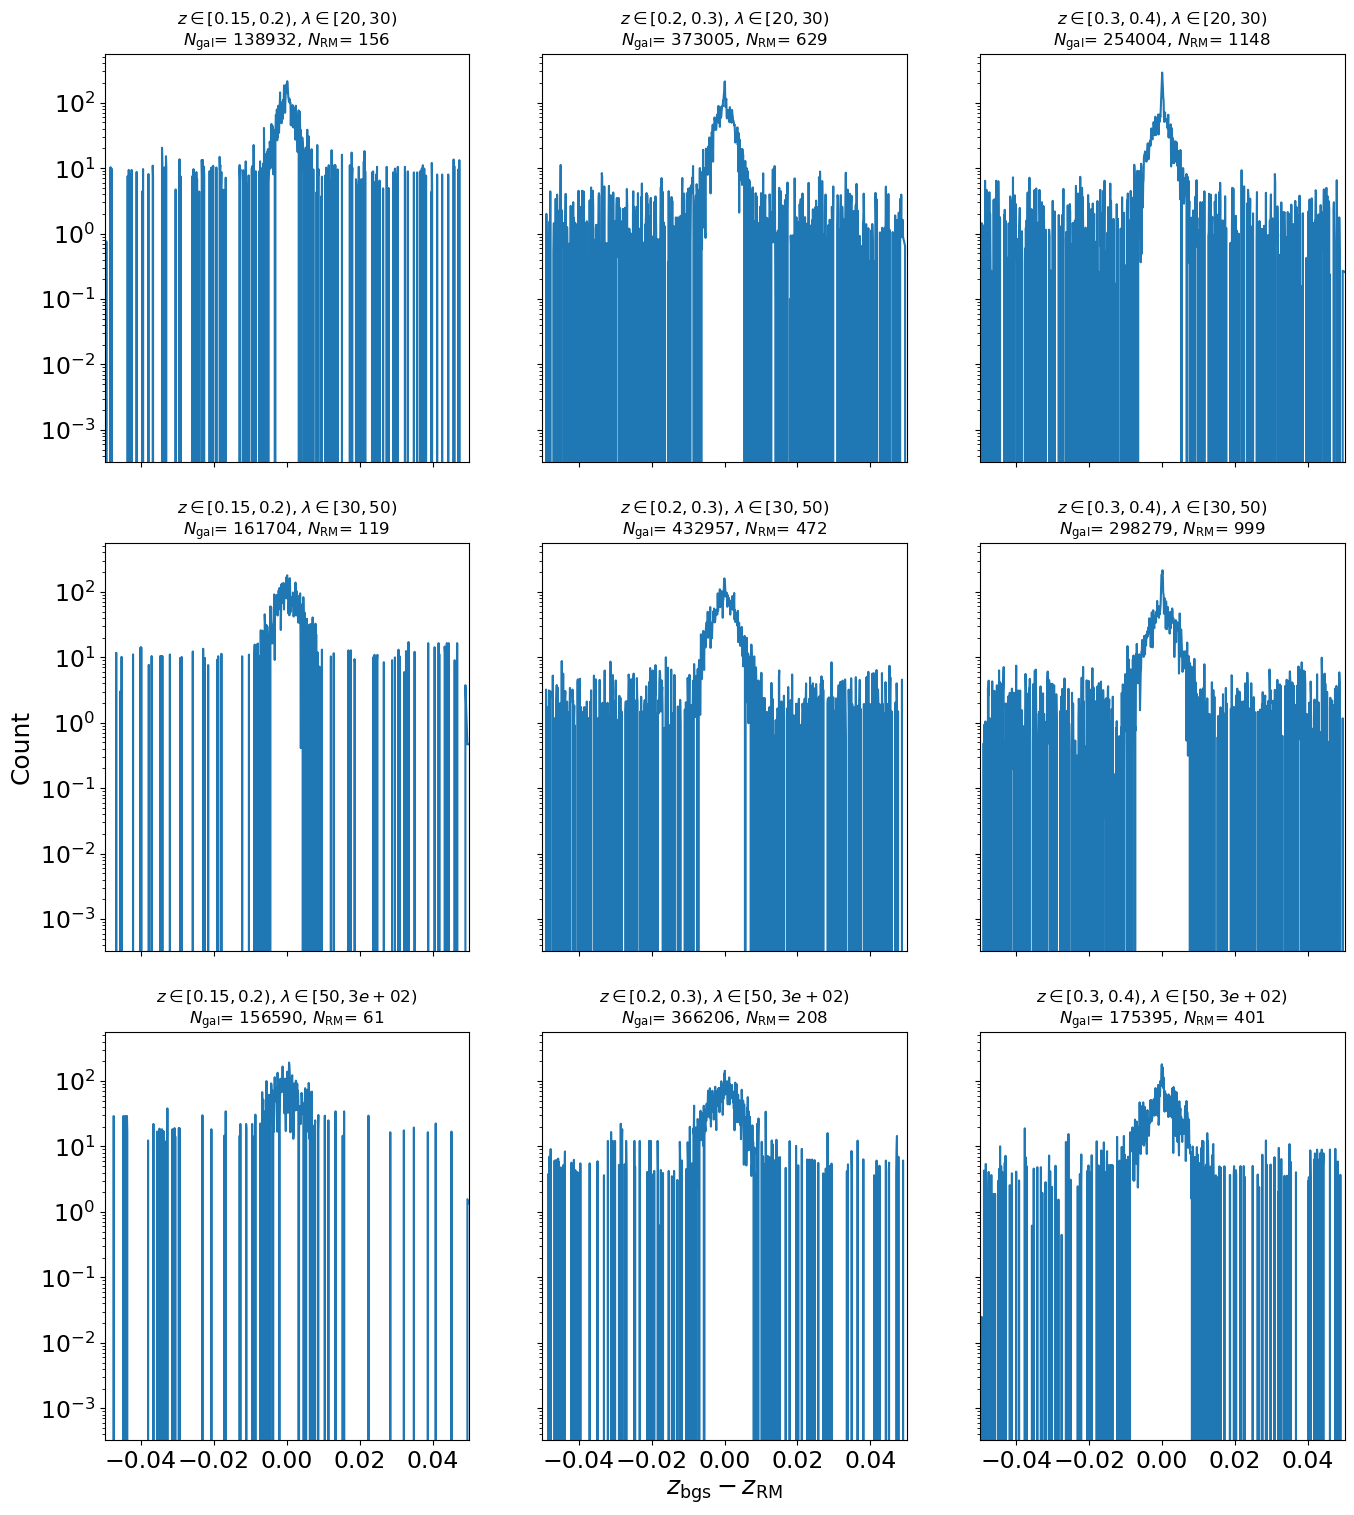

In [110]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,18), sharex='all', sharey='all')
#fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
for i, lmda_bin in enumerate(lmda_bins):
    #fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
    for j, z_bin in enumerate(z_bins):

            ##Apply cuts
            cut = (rm_matched['LAMBDA'] >= lmda_bin[0]) & (rm_matched['LAMBDA'] < lmda_bin[1])
            cut &=(rm_matched['Z_LAMBDA'] >= z_bin[0]) & (rm_matched['Z_LAMBDA'] < z_bin[1])
            rm_bin = rm_matched[cut]
            bgs_bin = bgs_matched[cut]


            z_diff = bgs_bin['Z'] - rm_bin['Z_SPEC_x']
            val, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)
            spectrum = Spectrum1D(flux=val*u.Jy, spectral_axis=binCent*u.um)
            g1_fit = fit_generic_continuum(spectrum, model=Chebyshev1D(3), median_window=3, exclude_regions=exclude_regions)
            y_continuum_fitted_1 = g1_fit(binCent*u.um)

            ax[i,j].plot(binCent, val-y_continuum_fitted_1.value)
            ax[i,j].set_yscale('log')
            ax[i,j].set_xlim([-0.05,0.05])
            #ax[i,j].hist(z_diff, bins=binBoundaries, density=True)
            ax[i,j].tick_params(axis='both', which='major', labelsize=17)
            ax[i,j].set_title(r'$z \in [{:.2g}, {:.2g})$, '.format(z_bin[0], z_bin[1],fontsize=12)+ \
                              r'$\lambda \in [{:.2g},{:.2g})$'.format(lmda_bin[0],lmda_bin[1],fontsize=12) + '\n' + \
                              r'$N_{\rm gal}$' + '= {:d}'.format(len(bgs_bin)) \
                              + r', $N_{\rm RM}$' + '= {:d}'.format(len(np.unique(rm_bin))))
            #ax[i,j].axhline(0.0, linestyle='--')
           
            ax[1,0].set_ylabel(r"Count", fontsize=18)
            ax[2,1].set_xlabel(r"$z_{\rm{bgs}} - z_{\rm{RM}}$"  , fontsize=18)
            
#plt.savefig('delta_zspec_bgs_rm_fullcut_zoomin.png')

plt.show()
#ax[0,0].legend(loc='upper left', fontsize=19)

## Kernel for projection effects
* Double Gaussian
* Laplacian
* Box
* Parabolic

### Best fit model 

In [338]:
def lnprior(p):
    sigma_1 = p[2]; sigma_2 = p[5]

    if (sigma_1 > 0.001) or (sigma_1 <= 0):
        return -np.inf

    if (sigma_2 <= 0.001) or (sigma_2 > 0.01):
        return -np.inf

    return 0

'''
Gaussian likelihood with heterodescitic errors ##!!To change to Poisson likelihood

Input:
p: 4-parameters of dimensions (N) or (N,M) with N the array of posterior samples
model: functional model for the fit (see functions below)
x: x data vector
y: y data vector
err: error on the y data vector

Returns:
lp: log probability
'''
def lnlike(p, model, x, y, err):
    # the likelihood is sum of the lot of normal distributions
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    err = err[:,np.newaxis]
    
    fit = model(p,x)
    if np.any(np.isnan(fit)):
        return -np.inf

    denom = np.power(err,2)
    lp = -0.5*np.sum(np.power((y - fit),2)/denom + np.log(denom) + np.log(2*np.pi), axis=0)
    lp = np.nan_to_num(lp, nan=-np.inf)
    return lp

'''
Double Gaussian model

def model(p,x):
    A_1 = p[0]; mu_1 = p[1]; sigma_1 = p[2]; A_2 = p[3]; mu_2 = p[4]; sigma_2 = p[5]
    #x = x[:,np.newaxis]
    model = A_1/np.sqrt(2*np.pi*sigma_1**2)* np.exp(-(x - mu_1) ** 2 / (2 * sigma_1 ** 2)) \
            +A_2/np.sqrt(2*np.pi*sigma_2**2)* np.exp(-(x - mu_2) ** 2 / (2 * sigma_2 ** 2))
    return model
'''

'''
Double Gaussian model with mean at 0
'''
def model(p,x):
    A_1 = p[0]; mu_1 = p[1]; sigma_1 = p[2]; A_2 = p[3]; mu_2 = p[4]; sigma_2 = p[5];
    
    #x = x[:,np.newaxis]
    model = A_1/np.sqrt(2*np.pi*sigma_1**2)* np.exp(-(x - mu_1) ** 2 / (2 * sigma_1 ** 2)) \
            +A_2/np.sqrt(2*np.pi*sigma_2**2)* np.exp(-(x - mu_2) ** 2 / (2 * sigma_2 ** 2))
    return model  

def lnprob(p, model, x, y, err):
    lp = lnprior(p)

    return lp + lnlike(p, model, x, y, err)
   

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


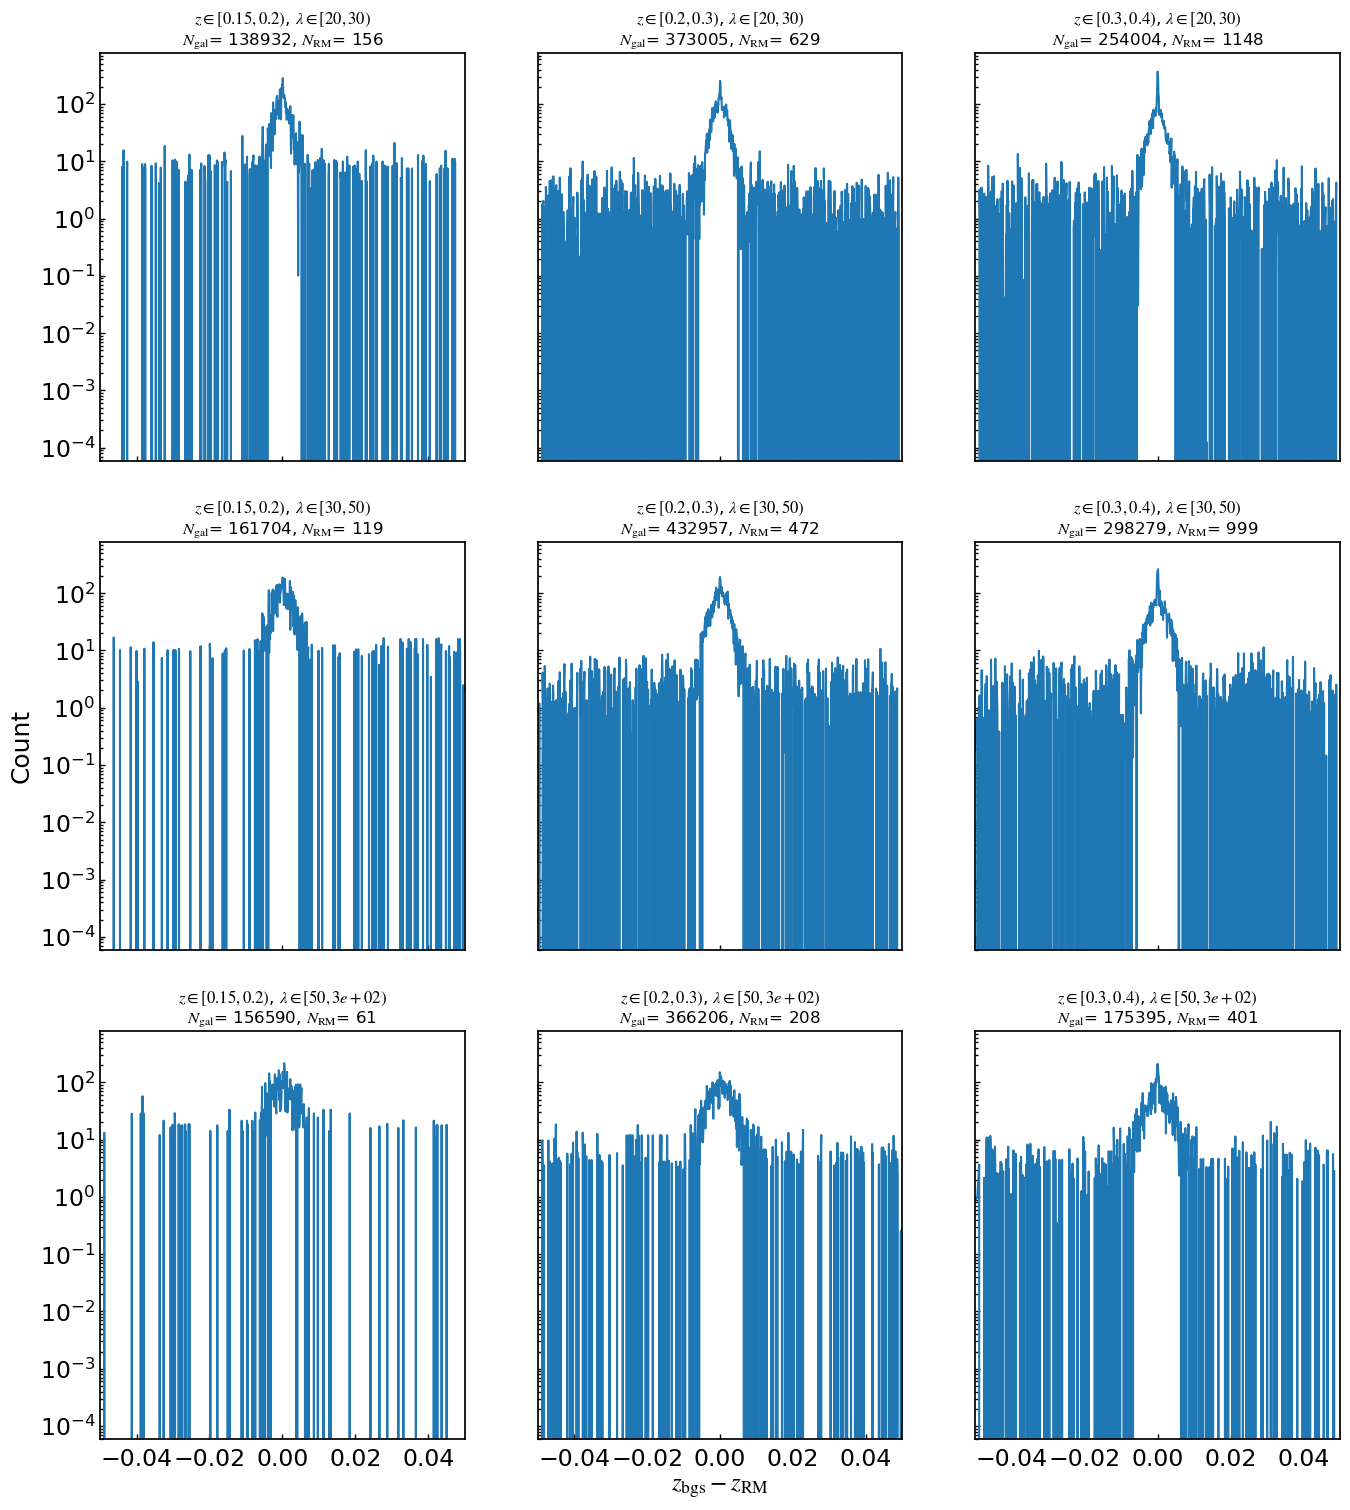

In [410]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,18), sharex='all', sharey='all')
#fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
for i, lmda_bin in enumerate(lmda_bins):
    #fig.suptitle(r"$\lambda \in [{:.2g},{:.2f})$".format(lmda_bins[k][0],lmda_bins[k][1]), fontsize=30)
    for j, z_bin in enumerate(z_bins):

            ##Apply cuts
            cut = (rm_matched['LAMBDA'] >= lmda_bin[0]) & (rm_matched['LAMBDA'] < lmda_bin[1])
            cut &=(rm_matched['Z_LAMBDA'] >= z_bin[0]) & (rm_matched['Z_LAMBDA'] < z_bin[1])
            rm_bin = rm_matched[cut]
            bgs_bin = bgs_matched[cut]

            z_diff = (bgs_bin['Z'] - rm_bin['Z_SPEC_x'])/(1+bgs_bin['Z'])
            val, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)
            spectrum = Spectrum1D(flux=val*u.Jy, spectral_axis=binCent*u.um)
            g1_fit = fit_generic_continuum(spectrum, model=Chebyshev1D(3), median_window=3, exclude_regions=exclude_regions)
            y_continuum_fitted_1 = g1_fit(binCent*u.um)

            ax[i,j].plot(binCent, val-y_continuum_fitted_1.value)
            ax[i,j].set_yscale('log')
            ax[i,j].set_xlim([-0.05,0.05])
            #ax[i,j].hist(z_diff, bins=binBoundaries, density=True)
            ax[i,j].tick_params(axis='both', which='major', labelsize=17)
            ax[i,j].set_title(r'$z \in [{:.2g}, {:.2g})$, '.format(z_bin[0], z_bin[1],fontsize=12)+ \
                              r'$\lambda \in [{:.2g},{:.2g})$'.format(lmda_bin[0],lmda_bin[1],fontsize=12) + '\n' + \
                              r'$N_{\rm gal}$' + '= {:d}'.format(len(bgs_bin)) \
                              + r', $N_{\rm RM}$' + '= {:d}'.format(len(np.unique(rm_bin))))
            #ax[i,j].axhline(0.0, linestyle='--')
           
            ax[1,0].set_ylabel(r"Count", fontsize=18)
            ax[2,1].set_xlabel(r"$z_{\rm{bgs}} - z_{\rm{RM}}$"  , fontsize=18)
            
#plt.savefig('delta_zspec_bgs_rm_fullcut_zoomin.png')

plt.show()
#ax[0,0].legend(loc='upper left', fontsize=19)

In [417]:
Nwalkers = 50
Nsample = int(2e4)
Ndim = 6 ## For Double Gaussian model

In [418]:
starting_params = [0.06, 0.0001, 0.0002, 0.5, 0.0001, 0.003]
p0 = np.array([starting_params*(1.0 + 0.01*np.random.randn(Ndim)) for j in range(Nwalkers)])

In [419]:
starting_model = model(starting_params, binCent)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

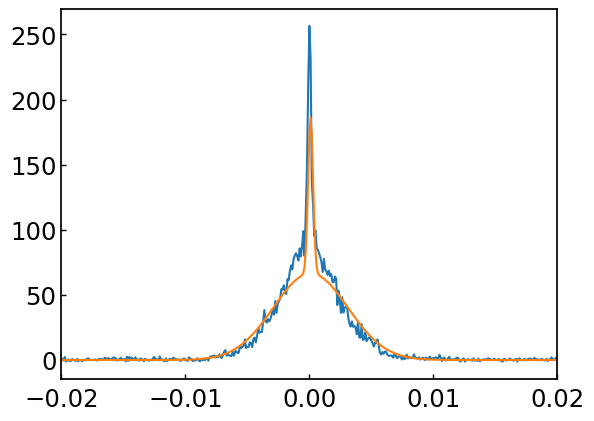

In [420]:
plt.plot(binCent, z_diff_fitted)
plt.plot(binCent, starting_model)
#plt.yscale('log')
plt.xlim([-0.02,0.02])
plt.show()

### Running chains

In [421]:
# Initialize the sampler        
sampler = emcee.EnsembleSampler(Nwalkers, Ndim, lnprob,
                    args=(model, binCent, z_diff_fitted, y_err)) ##No backend
        
sampler.run_mcmc(p0, Nsample, progress=True) 

100%|██████████| 20000/20000 [02:09<00:00, 154.63it/s]


State([[ 6.15360503e-02  1.16679091e-05  1.56182073e-04  5.05304241e-01
  -5.54150983e-06  2.57528723e-03]
 [ 6.55946916e-02  3.35087458e-06  1.45215871e-04  5.08903590e-01
   4.64581530e-05  2.48625911e-03]
 [ 5.92523214e-02  3.75642393e-06  1.46317043e-04  5.15007971e-01
   6.94192169e-05  2.52733211e-03]
 [ 7.08489188e-02  1.71418849e-05  1.65204733e-04  5.09222879e-01
  -3.18117959e-05  2.48773170e-03]
 [ 7.09722508e-02  3.76926000e-06  1.60536778e-04  5.05147471e-01
  -1.69831803e-05  2.55387974e-03]
 [ 6.54217464e-02  1.19201393e-05  1.67053805e-04  5.15018937e-01
   8.06099382e-05  2.51955732e-03]
 [ 6.67346353e-02  6.08164280e-06  1.53402629e-04  5.03730556e-01
  -3.87975970e-05  2.52958056e-03]
 [ 6.99761402e-02 -5.00520383e-06  1.48325229e-04  5.03508493e-01
   2.29333020e-05  2.50756210e-03]
 [ 6.59869217e-02  1.18585389e-05  1.53666969e-04  5.11024884e-01
   1.87483863e-05  2.50935544e-03]
 [ 6.55470276e-02  7.12350040e-06  1.54688976e-04  5.04164551e-01
  -2.66268381e-06  

In [422]:
chain = sampler.get_chain(flat=False, thin=10, discard=500)

In [423]:
def check_chains(chain, burn=0, maxlag=1000):
    '''
    Ignoring `burn` samples from the front of each chain, compute convergence criteria and
    effective number of samples.
    '''
    nsteps, nwalk, npars = chain.shape
    if burn >= nsteps: return
    tmp_samples = [chain[burn:,i,:] for i in range(nwalk)]
    print('R =', cr.GelmanRubinR(tmp_samples))
    #print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
    #print('NB: Since walkers are not independent, these will be optimistic!')
    return

In [424]:
check_chains(chain)

R = [1.00105794 1.00210618 1.0012253  1.00202657 1.00164211 1.00144402]


In [425]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.516


In [426]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time: 67.285 steps


In [427]:
flatchain = chain.reshape((-1,Ndim)).T

In [428]:
## Finding the best fit parameters and estimator

#a1, mu1, sigma1, a2, mu2, sigma2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), \
#                                       zip(*np.percentile(flatchain.T, [16, 50, 84], axis=0)))

a1, mu1, sigma1, a2, mu2, sigma2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), \
                                       zip(*np.percentile(flatchain.T, [16, 50, 84], axis=0)))
#print('m_tau: best fit, upper_err, lower_err', m_tau)
#print('m_offset: best fit, upper_err, lower_err', m_offset)
#print('m_height: best fit, upper_err, lower_err', m_height)
#print('m_scale: best fit, upper_err, lower_err', m_scale)

a1 = list(a1)
mu1 = list(mu1)
sigma1 = list(sigma1)
a2 = list(a2)
mu2 = list(mu2)
sigma2 = list(sigma2)

best_fit_params = [a1[0],mu1[0],sigma1[0],a2[0],mu2[0],sigma2[0]]
#best_fit_params = [a1[0],sigma1[0],a2[0],sigma2[0]]

In [429]:
best_fit_params

[0.06561586954400955,
 5.999177567872877e-06,
 0.00015764411053507976,
 0.504651547318818,
 2.3386411191186727e-05,
 0.0025400549517445047]

In [430]:
best_fit_model = model(best_fit_params, binCent)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

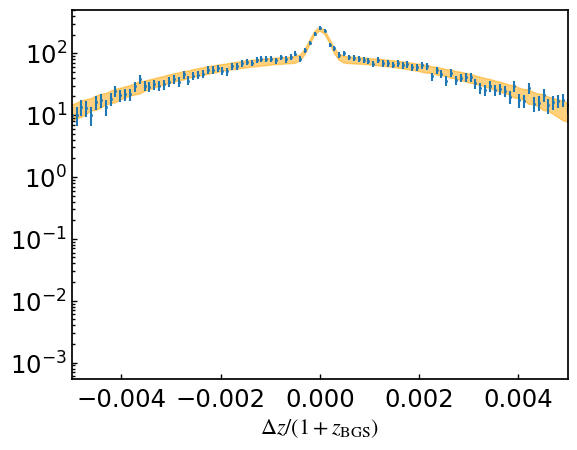

In [436]:
plt.errorbar(binCent, z_diff_fitted, yerr=y_err, marker='s', linestyle='None', markersize='1')
plt.fill_between(binCent, best_fit_model-1*y_err, best_fit_model+1*y_err, color='orange', alpha=0.5)
plt.xlim([-0.005,0.005])
#plt.ylim([1,500])
plt.yscale('log')
#plt.yscale('symlog', linthresh=1)
plt.xlabel(r'$\Delta z/(1+z_{\rm BGS})$', size=16)
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

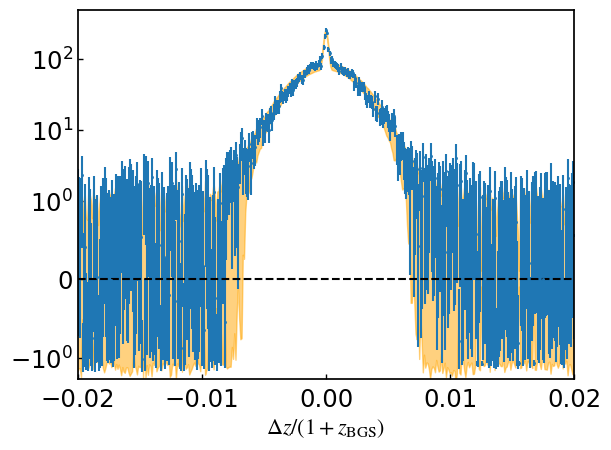

In [435]:
plt.errorbar(binCent, z_diff_fitted, yerr=y_err, marker='s', linestyle='None', markersize='1')
plt.fill_between(binCent, best_fit_model-1*y_err, best_fit_model+1*y_err, color='orange', alpha=0.5)
plt.xlim([-0.02,0.02])
plt.ylim([-2,500])
plt.axhline(0, linestyle='dashed', color='black')
#plt.yscale('log')
plt.yscale('symlog', linthresh=1)
plt.xlabel(r'$\Delta z/(1+z_{\rm BGS})$', size=16)
plt.show()

In [396]:
from scipy import stats

'''
Calculates the BIC for a given model.
model: function that inputs model
samples: flattened chain of (D,N), D the number of dimension and N total number of samples across all walkers;
x_data: x coordinates for data vectors
y_data: y coordinates for data vectors
y_err: y errors on the data points
'''
def BIC(model,samples, x_data, y_data, y_err):
    k = np.shape(samples)[0]
    p_best = list(map(lambda v: (v[0]), zip(*np.percentile(samples, [50], axis=1))))
    D = -2*lnlike(p_best, model, x_data, y_data, y_err)
    N = len(x_data)
    return D + k*np.log(N)


'''
model: function that inputs model
samples: flattened chain of (D,N), D the number of dimension and N total number of samples across all walkers;
data: data vector
best_p: best fit parameters
'''

def DIC(model, samples, x_data, y_data, y_err):
        """
        Compute the Deviance Information Criterion for the given model
        """
        # Compute the deviance D for each sample, using the vectorized code.
        
        ##This part needs to be completed. 
        D_avg = np.mean(-2.0*lnlike(samples, model, x_data, y_data, y_err)) ## Vectorized
        p_best = list(map(lambda v: (v[0]), zip(*np.percentile(samples, [50], axis=1))))
        
        D_best = -2.0**lnlike(p_best, model, x_data, y_data, y_err)
        DIC = 2*D_avg - D_best
        return DIC

'''
Calculates the DIC for a given model.
model: best fit model of dimensions (len(x),)
obs: Observed y data points
error: Error on the y-data points
'''
## Chi_squared estimator
def chisqr(model, obs, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-model[i])**2)/(error[i]**2)
    return chisqr


'''
chain: np.array in dimensions of (nsteps, nwalk, npars).  
model: The functional form of the model
Ndim: number of parameters for the model
x_data: the x data vector
y_data: the y data vector
y_err: error on the y data vector
verbose: If true, displays the best fit parameters and bounds, DIC, BIC and Chi-square right-tail p-value

Returns:
best_fit_params: (Ndim,3) array of the best fit parameters. For each parameter the 2nd axes denote [best_fit_val, upper_err, lower_err] using the (16,50,84) percentile bounds 
DIC_model: The DIC of the model
BIC_model: The BIC of the model
p_val: Chi-square right tail p-value
'''
def posterior_summary_stats(chain, model, Ndim, x_data, y_data, y_err, verbose=False):
 
    
    ##Turn into a flatchain
    flatchain = chain.reshape((-1,Ndim)).T
    
    ##Best fit parameters
    params_iter = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(flatchain, [16, 50, 84], axis=1)))
        
    best_fit_params = []
    for i, param_cur in enumerate(params_iter):
        best_fit_params.append(list(param_cur))
        
    best_fit_params = np.array(best_fit_params)
    model_best_fit = model(best_fit_params[:,0], x_data)
    
    ##Chi-square p-value
    p_val = 1 - stats.chi2.cdf(chisqr(model_best_fit, y_data, y_err) , len(y_data)-Ndim)
    
    ###DIC 
    reduce_sample = 1 #int(np.shape(flatchain)[1]/100) ## Count every 1000  
    DIC_model =  DIC(model, flatchain[:,::reduce_sample],  x_data, y_data, y_err)
    BIC_model =  BIC(model, flatchain[:,::reduce_sample],  x_data, y_data, y_err)
    
    if verbose:
        ##Check the convergence of chains
        check_chains(chain)
        
        ##Best fit params
        for i in range(len(best_fit_params)):
            print('param_{}: best fit, upper_err, lower_err: '.format(i), best_fit_params[i])
            
        ##DIC and BIC
        print("DIC: ", DIC_model)
        print("BIC: ", BIC_model)

        ##Chi-square p-value
        print('Chi-square: ', chisqr(model_best_fit, y_data, y_err))
        print('Chi-square p-value: ', p_val)
        
    return best_fit_params, DIC_model, BIC_model, p_val


In [397]:
## Statistics test
best_fit_params, DIC_nominal, BIC_nominal, p_val = posterior_summary_stats(chain, model, Ndim, binCent, \
                                                                           z_diff_fitted, y_err, verbose=True)

R = [1.00116352 1.00172593 1.00159175 1.00161371 1.00131212 1.00151845]
param_0: best fit, upper_err, lower_err:  [0.06782108 0.00419789 0.00413061]
param_1: best fit, upper_err, lower_err:  [4.65413794e-06 1.29750279e-05 1.29138332e-05]
param_2: best fit, upper_err, lower_err:  [2.06663039e-04 1.66789142e-05 1.51764363e-05]
param_3: best fit, upper_err, lower_err:  [0.51868063 0.00785977 0.00798514]
param_4: best fit, upper_err, lower_err:  [4.46783132e-05 4.58404041e-05 4.53164425e-05]
param_5: best fit, upper_err, lower_err:  [3.14925093e-03 4.22715054e-05 4.22881552e-05]
DIC:  [6439.40209837]
BIC:  [3255.36578984]
Chi-square:  604.334677264099
Chi-square p-value:  1.0


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

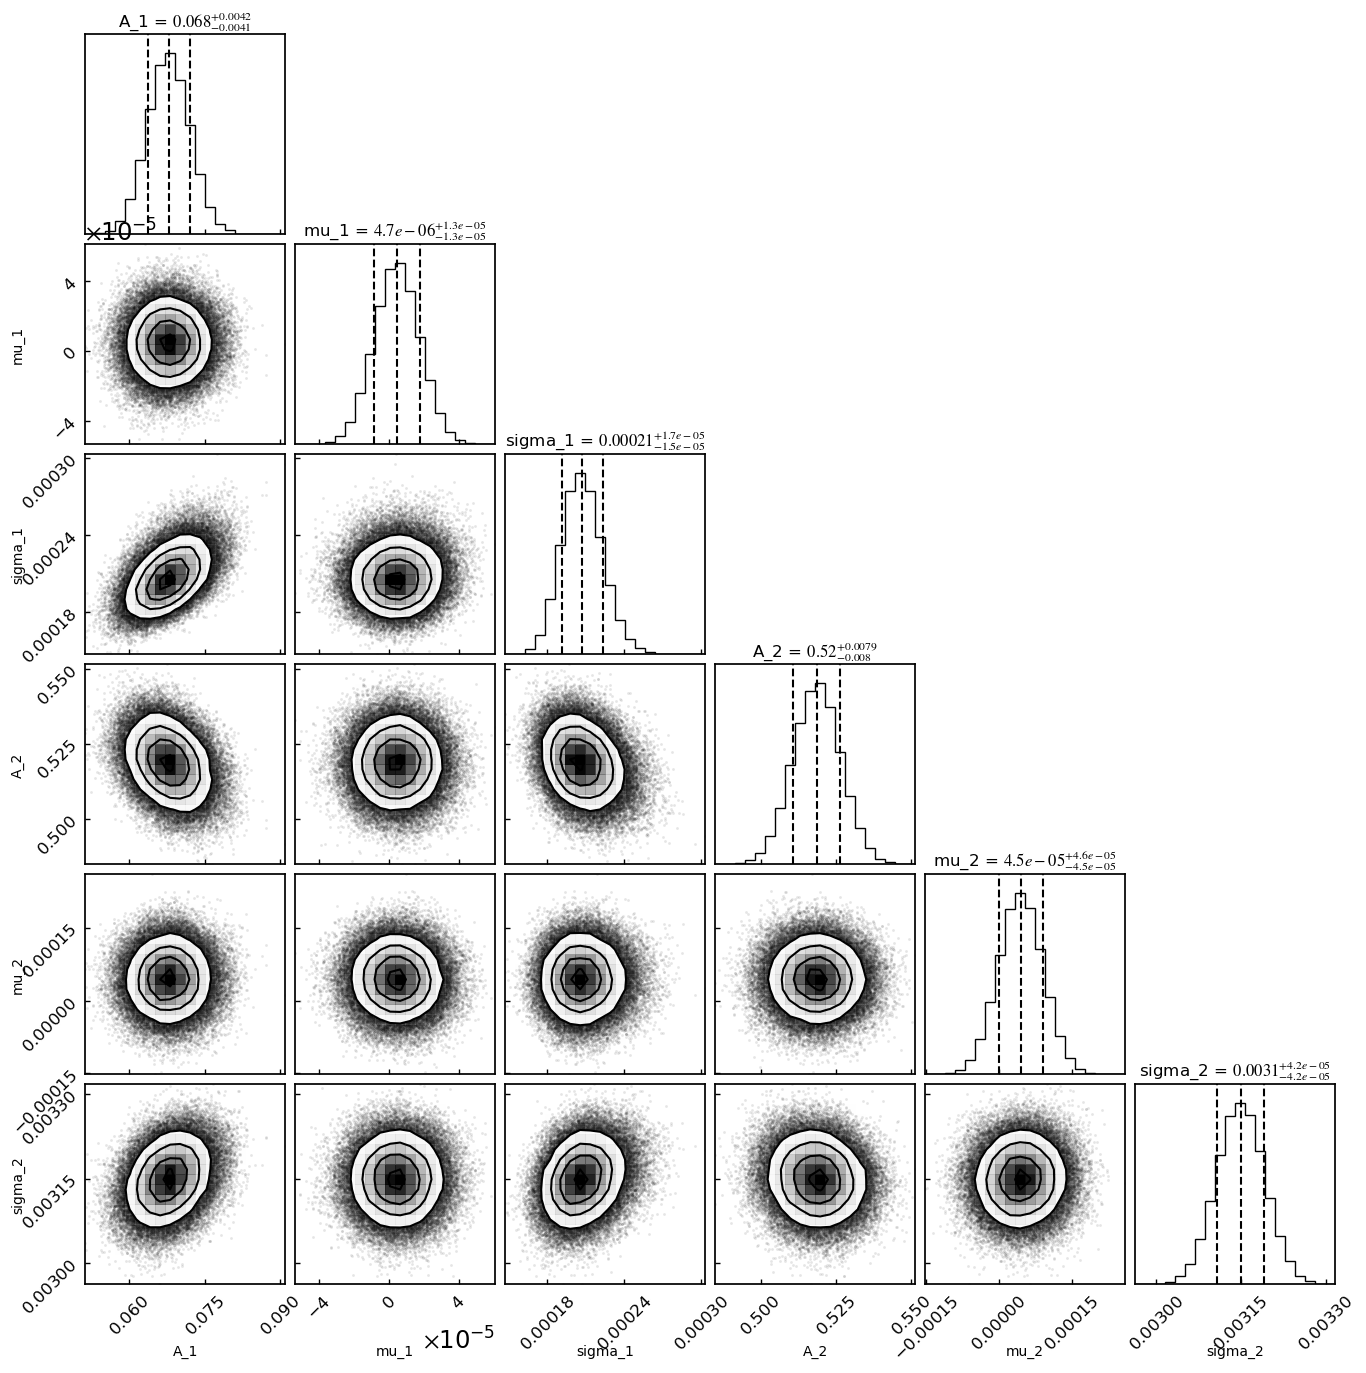

In [401]:
import corner
tmp = corner.corner(flatchain.T, labels=['A_1', 'mu_1', 'sigma_1', 'A_2', 'mu_2', 'sigma_2'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e12,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
tmp.savefig('mcmc_all_cornerplot.pdf')